In [10]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from time import perf_counter

plt.style.use("seaborn-v0_8-whitegrid")

# Rutas
MODELS_DIR   = os.path.join("..", "models")
TRAIN_DIR    = os.path.join("..", "data", "raw", "train")
EXAMPLES_DIR = os.path.join("..", "examples")

PRIMARY_MODEL  = os.path.join(MODELS_DIR, "modelo_mobilenetv2_finetuned.keras")
FALLBACK_MODEL = os.path.join(".",        "modelo_mobilenetv2_finetuned.keras")
CLASS_CSV      = os.path.join(MODELS_DIR, "class_names.csv")
IMG_SIZE = (224, 224)
EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def load_class_names():
    if os.path.isfile(CLASS_CSV):
        names = pd.read_csv(CLASS_CSV, header=None).iloc[:, 0].astype(str).tolist()
    else:
        names = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
    if not names:
        raise RuntimeError("No se pudieron cargar clases desde `../models/class_names.csv` ni `../data/raw/train`.")
    return names

def load_model():
    path = PRIMARY_MODEL if os.path.isfile(PRIMARY_MODEL) else FALLBACK_MODEL
    if not os.path.isfile(path):
        raise FileNotFoundError("No se encontró el modelo en `../models/modelo_mobilenetv2_finetuned.keras` ni en `./modelo_mobilenetv2_finetuned.keras`.")
    print(f"Modelo cargado desde: {os.path.abspath(path)}")
    return tf.keras.models.load_model(path)

CLASS_NAMES = load_class_names()
model = load_model()

Modelo cargado desde: D:\Diplomado IA\Proyecto final\ProyectoDeepLearning_FutbolEmociones\models\modelo_mobilenetv2_finetuned.keras


In [11]:
def list_images(folder):
    if not os.path.isdir(folder):
        return []
    files = [os.path.join(folder, f) for f in os.listdir(folder)]
    return sorted([p for p in files if os.path.splitext(p)[1].lower() in EXTS])

def preprocess_image(path, target_size=(224, 224)):
    img = Image.open(path).convert("RGB").resize(target_size)
    arr = np.array(img).astype("float32") / 255.0
    x = np.expand_dims(arr, axis=0)
    return x, img

def predict_image(model, image_path, topk=3):
    x, pil_img = preprocess_image(image_path, IMG_SIZE)
    t0 = perf_counter()
    probs = model.predict(x, verbose=0)[0]
    dt = perf_counter() - t0
    k = min(topk, len(CLASS_NAMES))
    idx_top = np.argsort(probs)[::-1][:k]
    return pil_img, probs, idx_top, dt

def plot_top3_bars(probs, idx_top, title="Top‑3 probabilidades"):
    labels = [CLASS_NAMES[i] for i in idx_top]
    vals = probs[idx_top]
    plt.figure(figsize=(4.5, 2.8))
    plt.bar(labels, vals, color="#4C72B0")
    plt.ylim(0, 1)
    plt.title(title)
    plt.ylabel("confianza")
    plt.tight_layout()
    plt.show()


Imagen: D:\Diplomado IA\Proyecto final\ProyectoDeepLearning_FutbolEmociones\examples\16240250776800.jpg
Predicción Top‑1: angry (conf=0.4438) · tiempo=787.4 ms


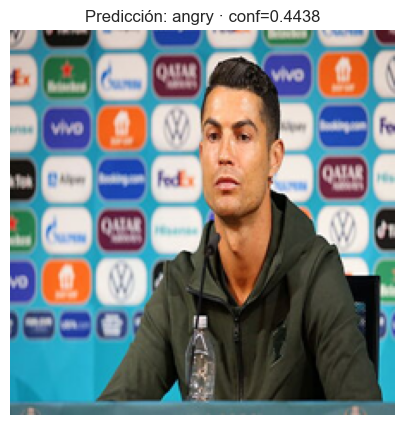

C:\Users\nigger\AppData\Local\Temp\ipykernel_4012\2034418114.py:30: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nigger\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


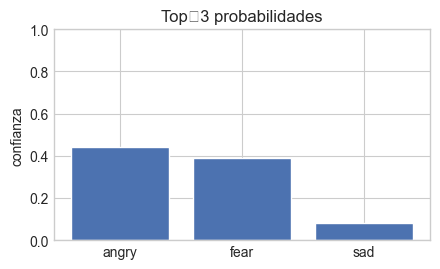

In [12]:
images = list_images(EXAMPLES_DIR)
if not images:
    raise FileNotFoundError("No hay imágenes en `../examples`. Coloca archivos .jpg/.png para continuar.")

sample_path = images[0]
pil_img, probs, idx_top, dt = predict_image(model, sample_path, topk=3)
top1 = idx_top[0]
print(f"Imagen: {os.path.abspath(sample_path)}")
print(f"Predicción Top‑1: {CLASS_NAMES[top1]} (conf={probs[top1]:.4f}) · tiempo={dt*1000:.1f} ms")

plt.figure(figsize=(5, 5))
plt.imshow(pil_img); plt.axis("off")
plt.title(f"Predicción: {CLASS_NAMES[top1]} · conf={probs[top1]:.4f}")
plt.show()

plot_top3_bars(probs, idx_top)

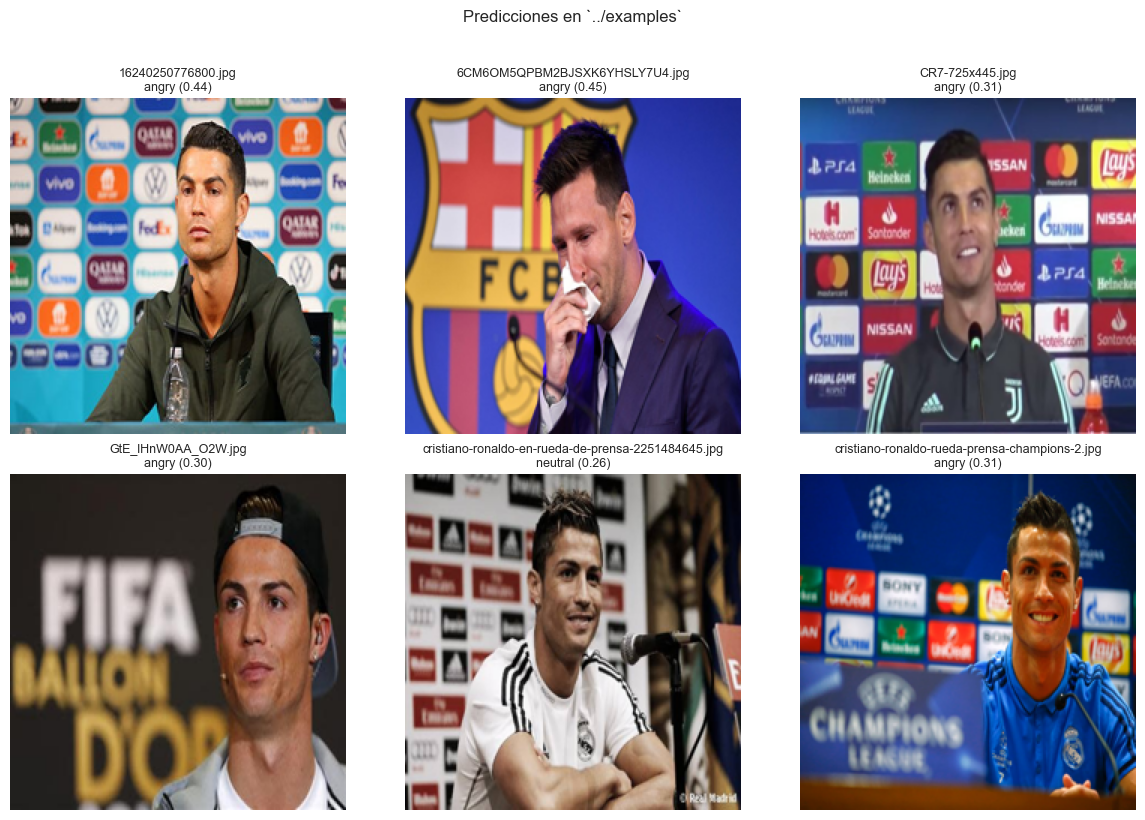

In [13]:
cols = 3
rows = int(np.ceil(len(images) / cols))
plt.figure(figsize=(cols * 4, max(1, rows) * 4))
for i, path in enumerate(images):
    pil_img, probs, idx_top, dt = predict_image(model, path, topk=3)
    top1 = idx_top[0]
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(pil_img); plt.axis("off")
    ax.set_title(f"{os.path.basename(path)}\n{CLASS_NAMES[top1]} ({probs[top1]:.2f})", fontsize=9)
plt.suptitle("Predicciones en `../examples`", y=1.02)
plt.tight_layout(); plt.show()